In [ ]:
# # Install meridian: from PyPI @ latest release
# !pip install --upgrade google-meridian[colab,and-cuda,schema]
# #
# # Install meridian: from PyPI @ specific version
# !pip install google-meridian[colab,and-cuda,schema]==1.3.1

# # Install meridian: from GitHub @HEAD
# !pip install --upgrade "google-meridian[colab,and-cuda,schema] @ git+https://github.com/google/meridian.git@main"

In [ ]:
import IPython
import arviz as az

from meridian import constants
from meridian.analysis import analyzer
anlz = analyzer.Analyzer(mmm)

from meridian.analysis import optimizer
from meridian.analysis import summarizer
from meridian.analysis import visualizer
from meridian.analysis.review import reviewer
from meridian.model import model
from meridian.model import prior_distribution

from meridian.model import spec
from schema.serde import meridian_serde
import numpy as np
import pandas as pd
# check if GPU is available
from psutil import virtual_memory
import tensorflow as tf
import tensorflow_probability as tfp
from meridian.data.data_frame_input_data_builder import DataFrameInputDataBuilder

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print(
    'Num GPUs Available: ',
    len(tf.config.experimental.list_physical_devices('GPU')),
)
print(
    'Num CPUs Available: ',
    len(tf.config.experimental.list_physical_devices('CPU')),
)

Your runtime has 13.6 gigabytes of available RAM

Num GPUs Available:  0
Num CPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
csv_path = "/content/drive/MyDrive/model_input_BrandA_BrandA_SKU2.csv"
df = pd.read_csv(csv_path)
df.head()


,Week,Geo,KPI,TV_Impressions,YouTube_Impressions,Facebook_Impressions,Instagram_Impressions,Print_Readership,Radio_Listenership,Trade_Spend,...,FB_Banner_Content_Score,IG_Banner_Content_Score,Weighted_Distribution,Numeric_Distribution,TDP,NOS,CPI,GDP_Growth,Festival_Index,Rainfall_Index
0,2022-07-04,CENTRAL,19452.418311,487196.608834,225823.887786,231308.158354,68295.593393,38550.908730,539119.412767,12108.945933,...,74.714021,77.999979,0.326712,0.406848,36.923185,3.071753,120.954667,5.244440,1.180806,5.378450
1,2022-07-11,CENTRAL,33135.433050,419687.420180,247236.306855,144005.721169,63847.833488,52415.134577,502617.785975,71092.146150,...,67.773953,62.534974,0.339841,0.435635,39.028371,2.861870,121.348852,5.172292,1.180806,4.885889
2,2022-07-18,CENTRAL,33341.328755,507510.961798,208429.729963,163982.176918,58084.163684,45448.483465,385646.470655,73031.929192,...,79.726832,81.853852,0.383476,0.459516,42.920417,3.336179,121.739493,5.527240,1.180806,4.296654
3,2022-07-25,CENTRAL,27516.245000,549579.303459,255404.497347,226797.727697,73760.672239,52094.020050,402392.467193,8776.111839,...,72.749101,88.093330,0.399021,0.530084,45.159635,3.658301,122.123099,5.895747,1.180806,4.950548
4,2022-08-01,CENTRAL,28649.780592,559493.924637,301484.146940,170146.980769,77311.527465,54311.277643,648146.941022,9225.910162,...,76.299467,66.249756,0.393911,0.438237,50.585126,3.834527,122.496281,5.440235,1.180806,4.373309


In [ ]:
# Standardize required column names for the builder
df["Week"] = pd.to_datetime(df["Week"])

df_b = (
    df.rename(columns={"Week": "time", "Geo": "geo", "KPI": "kpi"})
      .sort_values(["geo", "time"])
      .reset_index(drop=True)
)

# Keep raw KPI for reference + log1p transform for modeling
df_b["kpi_raw"] = df_b["kpi"]
# df_b["kpi"] = np.log1p(df_b["kpi_raw"])

df_b.head(2)

,time,geo,kpi,TV_Impressions,YouTube_Impressions,Facebook_Impressions,Instagram_Impressions,Print_Readership,Radio_Listenership,Trade_Spend,...,IG_Banner_Content_Score,Weighted_Distribution,Numeric_Distribution,TDP,NOS,CPI,GDP_Growth,Festival_Index,Rainfall_Index,kpi_raw
0,2022-07-04,CENTRAL,19452.418311,487196.608834,225823.887786,231308.158354,68295.593393,38550.908730,539119.412767,12108.945933,...,77.999979,0.326712,0.406848,36.923185,3.071753,120.954667,5.244440,1.180806,5.378450,19452.418311
1,2022-07-11,CENTRAL,33135.433050,419687.420180,247236.306855,144005.721169,63847.833488,52415.134577,502617.785975,71092.146150,...,62.534974,0.339841,0.435635,39.028371,2.861870,121.348852,5.172292,1.180806,4.885889,33135.433050


In [ ]:
# Media exposures (keep Facebook only)
media_cols = ["TV_Impressions", "Facebook_Impressions", "Print_Readership", "Radio_Listenership"]
media_channels = ["TV", "Facebook", "Print", "Radio"]

# Controls (exclude Trade_Spend; will be used as spend proxy for media later)
control_cols = [
    "MRP","Net_Price","Feature_Flag","Display_Flag","TPR_Flag",
    "FB_Banner_Content_Score","IG_Banner_Content_Score",
    "Weighted_Distribution","Numeric_Distribution","TDP","NOS",
    "CPI","GDP_Growth","Festival_Index","Rainfall_Index"
]


In [ ]:
# Builder
builder = DataFrameInputDataBuilder(kpi_type="revenue")

# KPI
builder = builder.with_kpi(df=df_b, time_col="time", geo_col="geo")

# Spend proxies
for ch in media_channels:
    df_b[f"{ch}_spend"] = df_b["Trade_Spend"].astype(float)

media_spend_cols = [f"{ch}_spend" for ch in media_channels]

# Media
builder = builder.with_media(
    df=df_b,
    media_cols=media_cols,
    media_spend_cols=media_spend_cols,
    media_channels=media_channels,
    time_col="time",
    geo_col="geo",
)

# Controls
builder = builder.with_controls(
    df=df_b,
    control_cols=control_cols,
    time_col="time",
    geo_col="geo",
)

# Population (required for non-national)
df_b["population"] = 1_000_000
builder = builder.with_population(df=df_b, population_col="population", geo_col="geo")

# Build InputData
input_data = builder.build()


/usr/local/lib/python3.12/dist-packages/meridian/data/input_data.py:517: UserWarning: Revenue from the `kpi` data is used when `kpi_type`=`revenue`. `revenue_per_kpi` is ignored.
  warnings.warn(


In [ ]:
roi_mu = 0.2
roi_sigma = 0.9

prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(roi_mu, roi_sigma, name=constants.ROI_M)
)

model_spec = spec.ModelSpec(prior=prior, enable_aks=True)

mmm = model.Meridian(input_data=input_data, model_spec=model_spec)


In [ ]:
%%time
mmm.sample_prior(500)

mmm.sample_posterior(
    n_chains=10,
    n_adapt=2000,
    n_burnin=500,
    n_keep=1000,
    seed=0
)


/usr/local/lib/python3.12/dist-packages/meridian/model/knots.py:505: RuntimeWarning: overflow encountered in cast
  np.float32(math.comb(ncol, design_mat.shape[1]))


CPU times: user 1h 16min 38s, sys: 2min 31s, total: 1h 19min 10s
Wall time: 1h 3min 11s


In [ ]:
reviewer.ModelReviewer(mmm).run()

Model Quality Checks
Overall Status: PASS
Summary: Passed with reviews: Review is needed.

Check Results:
----------------------------------------
Convergence Check:
  Status: PASS
  Recommendation: The model has likely converged, as all parameters have R-hat values < 1.2.
----------------------------------------
Baseline Check:
  Status: REVIEW
  Recommendation: The posterior probability that the baseline is negative is 0.37. This indicates that the baseline time series occasionally dips into negative values. We recommend visually inspecting the baseline time series in the Model Fit charts, but don't be overly concerned. An occasional, small dip may indicate minor statistical error, which is inherent in any model.
----------------------------------------
BayesianPPP Check:
  Status: PASS
  Recommendation: The Bayesian posterior predictive p-value is 1.00. The observed total outcome is consistent with the model's posterior predictive distribution.
--------------------------------------


**Model selection** (Combine vs Drop multicollinear channels).
We trained two Meridian MMM variants to address extreme multicollinearity among YouTube/Facebook/Instagram: (A) combining them into a single “Digital” channel and (B) dropping the collinear channels. Both models converged and achieved nearly identical fit (R²≈0.95, wMAPE≈0.12). We selected the Drop model as the primary specification because it had a lower posterior probability of negative baseline (0.37 vs 0.54), indicating a slightly more stable baseline component while maintaining essentially the same predictive accuracy.

In [ ]:
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()

alt.LayerChart(...)

In [ ]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

alt.LayerChart(...)

In [ ]:
mmm_summarizer = summarizer.Summarizer(mmm)    #creates a summarizer tied to the trained MMM object.

In [ ]:

candidates = []

for attr in ["kpi", "media", "controls", "non_media_treatments", "organic_media"]:
    if hasattr(mmm.input_data, attr):
        da = getattr(mmm.input_data, attr)
        # xarray DataArray / Dataset have coords
        if hasattr(da, "coords") and ("time" in da.coords):
            candidates.append(pd.to_datetime(da.coords["time"].values))

if not candidates:
    raise ValueError("Couldn't find a 'time' coordinate in input_data objects.")

t = candidates[0]
start_date = pd.to_datetime(t.min()).strftime("%Y-%m-%d")
end_date   = pd.to_datetime(t.max()).strftime("%Y-%m-%d")

print("start_date =", start_date)
print("end_date   =", end_date)


start_date = 2022-07-04
end_date   = 2025-06-23


In [ ]:
from pathlib import Path
from IPython.display import HTML, display

meridian_root = Path("/content/outputs")
meridian_root.mkdir(parents=True, exist_ok=True)

out_html = meridian_root / "summary_output.html"

start_date = "2022-07-04"
end_date   = "2025-06-23"

mmm_summarizer.output_model_results_summary(
    out_html.name,       # filename
    str(meridian_root),  # folder
    start_date,
    end_date,
)

display(HTML(filename=str(out_html)))


/usr/local/lib/python3.12/dist-packages/meridian/analysis/analyzer.py:3348: UserWarning: Effectiveness is not reported because it does not have a clear interpretation by time period.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/meridian/analysis/analyzer.py:1027: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  warnings.warn(


Dataset,R-squared,MAPE,wMAPE
All Data,0.99,3%,2%


In [ ]:
%%time
budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize()

CPU times: user 16min 27s, sys: 2.97 s, total: 16min 30s
Wall time: 10min 15s


In [ ]:
from pathlib import Path
from IPython.display import HTML, display

filepath = Path("/content/outputs")
filepath.mkdir(parents=True, exist_ok=True)

optimization_results.output_optimization_summary(
    "optimization_output.html",
    filepath
)

display(HTML(filename=str(filepath / "optimization_output.html")))


Channel,Non-optimized spend,Optimized spend
TV,25%,32%
Radio,25%,31%
Print,25%,19%
Facebook,25%,18%


**Change in optimized spend for each channel**

This bar chart shows how the optimizer wants to reallocate budget relative to the current baseline. In your results, the model recommends shifting spend away from Facebook (−$20M) and Print (−$16M), and increasing investment in TV (+$20M) and Radio (+$16M). In short: the optimizer believes TV and Radio are currently under-funded given the learned response curves, while Facebook and Print are over-funded at the margin.

**Optimized budget allocation**

This pie chart shows the final recommended split of the total budget after optimization. The optimized plan allocates the largest shares to TV and Radio, with Print and Facebook receiving smaller portions. This matches the change chart: budget is being rebalanced toward TV/Radio because they are estimated to deliver higher incremental return under the model.

**Optimized incremental revenue & budget reallocation (waterfall + allocation table)**

This view summarizes the net impact of reallocating budget across channels. The waterfall chart shows how each channel’s spend change contributes to the total incremental revenue change (red bars = channels where spend is reduced and revenue decreases accordingly; blue bars = channels where spend increases and revenue rises). The table on the right reports the before vs. after budget shares, making it easy to see which channels the optimizer shifts money toward (higher share) and away from (lower share) under the chosen constraints.

**Channel response curves (spend → incremental revenue)**

These plots show each channel’s estimated response curve: incremental revenue increases with spend but with diminishing returns (curves flatten as spend grows). The markers indicate the current (non-optimized) spend vs the optimized spend for each channel; when the optimized point moves left/right, it means the optimizer is recommending less/more spend because the model believes the marginal return is lower/higher relative to the other channels. Together, these curves explain why the optimizer reallocates budget: it pushes spend toward channels that still sit on the steeper (higher marginal ROI) part of the curve and pulls spend away from channels that are already near saturation.

**Ot of Sample**

In [ ]:


HOLDOUT_WEEKS = 12
df_b["time"] = pd.to_datetime(df_b["time"])

all_weeks = df_b["time"].drop_duplicates().sort_values()
holdout_weeks = all_weeks.tail(HOLDOUT_WEEKS)

holdout_start = holdout_weeks.min()
holdout_end   = holdout_weeks.max()

print("Holdout weeks:", len(holdout_weeks))
print("Holdout range:", holdout_start.date(), "→", holdout_end.date())


Holdout weeks: 12
Holdout range: 2025-04-07 → 2025-06-23


In [ ]:

# DROPPING case media
media_cols = ["TV_Impressions", "Facebook_Impressions", "Print_Readership", "Radio_Listenership"]
media_channels = ["TV", "Facebook", "Print", "Radio"]

# spend proxies
for ch in media_channels:
    df_b[f"{ch}_spend"] = df_b["Trade_Spend"].astype(float)
media_spend_cols = [f"{ch}_spend" for ch in media_channels]

# controls (same as your working run)
control_cols = [
    "MRP","Net_Price","Feature_Flag","Display_Flag","TPR_Flag",
    "FB_Banner_Content_Score","IG_Banner_Content_Score",
    "Weighted_Distribution","Numeric_Distribution","TDP","NOS",
    "CPI","GDP_Growth","Festival_Index","Rainfall_Index"
]

# population required for geo models
df_b["population"] = 1_000_000

builder = DataFrameInputDataBuilder(kpi_type="revenue")
builder = builder.with_kpi(df=df_b, time_col="time", geo_col="geo")

builder = builder.with_media(
    df=df_b,
    media_cols=media_cols,
    media_spend_cols=media_spend_cols,
    media_channels=media_channels,
    time_col="time",
    geo_col="geo",
)

builder = builder.with_controls(
    df=df_b,
    control_cols=control_cols,
    time_col="time",
    geo_col="geo",
)

builder = builder.with_population(df=df_b, population_col="population", geo_col="geo")

input_data = builder.build()


/usr/local/lib/python3.12/dist-packages/meridian/data/input_data.py:517: UserWarning: Revenue from the `kpi` data is used when `kpi_type`=`revenue`. `revenue_per_kpi` is ignored.
  warnings.warn(


In [ ]:
# Create geo/time lists in the exact order Meridian expects
geos  = sorted(df_b["geo"].unique())
times = all_weeks.to_list()  # already sorted

# True for holdout weeks, for every geo
holdout_time_mask = np.array([t in set(holdout_weeks) for t in times], dtype=bool)
holdout_id = np.tile(holdout_time_mask, (len(geos), 1))  # (n_geos, n_times)

print("holdout_id shape:", holdout_id.shape, "| holdout weeks flagged:", holdout_time_mask.sum())


holdout_id shape: (8, 156) | holdout weeks flagged: 12


In [ ]:
import time
t0 = time.time()

mmm.sample_prior(500)
mmm.sample_posterior(
    n_chains=10, n_adapt=2000, n_burnin=500, n_keep=1000, seed=0
)

print("Elapsed minutes:", (time.time() - t0)/60)


Elapsed minutes: 56.724445923169455


In [ ]:
# Times as strings
all_times_str = [pd.Timestamp(t).strftime("%Y-%m-%d") for t in all_weeks.to_list()]
holdout_times_str = [pd.Timestamp(t).strftime("%Y-%m-%d") for t in holdout_weeks.to_list()]

train_times_str = [t for t in all_times_str if t not in set(holdout_times_str)]

def acc_table(selected_times, label):
    ds = anlz.predictive_accuracy(selected_times=selected_times, use_kpi=False, batch_size=100)
    df = ds.to_dataframe().reset_index()  # columns: metric, geo_granularity, value
    df["evaluation_set"] = label
    return df

df_train = acc_table(train_times_str, "Train")
df_test  = acc_table(holdout_times_str, "Test")

acc_df = pd.concat([df_train, df_test], ignore_index=True)

# Make a nice wide table
wide = (
    acc_df.pivot_table(
        index=["evaluation_set", "metric"],
        columns="geo_granularity",
        values="value"
    )
    .reset_index()
    .rename(columns={"geo": "geo_level", "national": "national_level"})
)

# format
wide["geo_level"] = wide["geo_level"].map(lambda x: f"{x:.4f}")
wide["national_level"] = wide["national_level"].map(lambda x: f"{x:.4f}")

print("Train window:", pd.to_datetime(train_times_str[0]).date(), "→", pd.to_datetime(train_times_str[-1]).date(), f"({len(train_times_str)} weeks)")
print("Test  window:", holdout_start.date(), "→", holdout_end.date(), f"({len(holdout_times_str)} weeks)")
display(wide)


/tmp/ipython-input-550988551.py:4: DeprecationWarning: The `meridian` argument is deprecated and will be removed in a future version. Use `model_context` instead.
  anlz = analyzer.Analyzer(mmm)


Train window: 2022-07-04 → 2025-03-31 (144 weeks)
Test  window: 2025-04-07 → 2025-06-23 (12 weeks)


geo_granularity,evaluation_set,metric,geo_level,national_level
0,Test,MAPE,0.1343,0.0185
1,Test,R_Squared,0.9483,0.9529
2,Test,wMAPE,0.1117,0.0182
3,Train,MAPE,0.1457,0.0277
4,Train,R_Squared,0.9480,0.9889
5,Train,wMAPE,0.1200,0.0244


In [ ]:
# Rolling backtest (multiple holdout windows)
HOLDOUT_WEEKS = 12
N_SPLITS = 6          # try 4–8
STEP_WEEKS = 12       # move the window by 12 weeks each split (non-overlapping)

all_weeks = pd.to_datetime(df_b["time"].drop_duplicates()).sort_values().to_list()
all_times_str = [pd.Timestamp(t).strftime("%Y-%m-%d") for t in all_weeks]

def acc_for_times(times_str, label, split_id, start_date, end_date):
    ds = anlz.predictive_accuracy(selected_times=times_str, use_kpi=False, batch_size=100)
    df = ds.to_dataframe().reset_index()   # metric, geo_granularity, value
    df["split_id"] = split_id
    df["evaluation_set"] = label
    df["window_start"] = start_date
    df["window_end"] = end_date
    return df

rows = []
T = len(all_times_str)

for s in range(N_SPLITS):
    # define holdout window indices (counting from the end backwards)
    end_idx = T - s * STEP_WEEKS
    start_idx = end_idx - HOLDOUT_WEEKS
    if start_idx <= 0:
        break

    test_times = all_times_str[start_idx:end_idx]
    train_times = all_times_str[:start_idx]

    rows.append(acc_for_times(train_times, "Train", s, train_times[0], train_times[-1]))
    rows.append(acc_for_times(test_times,  "Test",  s, test_times[0],  test_times[-1]))

backtest_df = pd.concat(rows, ignore_index=True)

# Make a readable wide table for quick inspection
wide = (
    backtest_df.pivot_table(
        index=["split_id", "evaluation_set", "window_start", "window_end", "metric"],
        columns="geo_granularity",
        values="value"
    )
    .reset_index()
    .rename(columns={"geo": "geo_level", "national": "national_level"})
    .sort_values(["split_id", "evaluation_set", "metric"])
)

display(wide.head(30))
print("Total splits computed:", wide["split_id"].nunique())


/tmp/ipython-input-3200804191.py:8: DeprecationWarning: The `meridian` argument is deprecated and will be removed in a future version. Use `model_context` instead.
  anlz = analyzer.Analyzer(mmm)


geo_granularity,split_id,evaluation_set,window_start,window_end,metric,geo_level,national_level
0,0,Test,2025-04-07,2025-06-23,MAPE,0.134299,0.018474
1,0,Test,2025-04-07,2025-06-23,R_Squared,0.948293,0.952912
2,0,Test,2025-04-07,2025-06-23,wMAPE,0.111689,0.018242
3,0,Train,2022-07-04,2025-03-31,MAPE,0.145707,0.027665
4,0,Train,2022-07-04,2025-03-31,R_Squared,0.948027,0.988945
5,0,Train,2022-07-04,2025-03-31,wMAPE,0.120033,0.024421
6,1,Test,2025-01-13,2025-03-31,MAPE,0.171911,0.034659
7,1,Test,2025-01-13,2025-03-31,R_Squared,0.904046,0.857975
8,1,Test,2025-01-13,2025-03-31,wMAPE,0.144243,0.034199
9,1,Train,2022-07-04,2025-01-06,MAPE,0.143325,0.027029


Total splits computed: 6


In [ ]:
# ============================================================
# Step 2 — Summarize rolling backtest stability (TEST only)
# ============================================================


# wide is the dataframe you displayed (split_id, evaluation_set, window_start, window_end, metric, geo_level, national_level)
test_wide = wide[wide["evaluation_set"] == "Test"].copy()

# Convert to numeric
test_wide["geo_level"] = pd.to_numeric(test_wide["geo_level"], errors="coerce")
test_wide["national_level"] = pd.to_numeric(test_wide["national_level"], errors="coerce")

# Summary stats across splits for each metric
summary = (
    test_wide
    .groupby("metric")[["geo_level", "national_level"]]
    .agg(["mean", "std", "min", "max"])
    .reset_index()
)

# Flatten column names
summary.columns = ["metric"] + [f"{lvl}_{stat}" for lvl, stat in summary.columns[1:]]
summary = summary.sort_values("metric")

display(summary)

# Also show per-split TEST wMAPE + R^2
per_split = test_wide.pivot_table(
    index=["split_id", "window_start", "window_end"],
    columns="metric",
    values=["geo_level", "national_level"]
).reset_index()

#column names
per_split.columns = ["_".join([c for c in col if c]) for col in per_split.columns.values]
display(per_split.sort_values("split_id"))


,metric,geo_level_mean,geo_level_std,geo_level_min,geo_level_max,national_level_mean,national_level_std,national_level_min,national_level_max
0,MAPE,0.147127,0.015250,0.132900,0.171911,0.018830,0.009133,0.007716,0.034659
1,R_Squared,0.943602,0.020508,0.904046,0.960698,0.954113,0.051207,0.857975,0.995859
2,wMAPE,0.117300,0.013706,0.106483,0.144243,0.018289,0.009759,0.007105,0.034199


,split_id,window_start,window_end,geo_level_MAPE,geo_level_R_Squared,geo_level_wMAPE,national_level_MAPE,national_level_R_Squared,national_level_wMAPE
0,0,2025-04-07,2025-06-23,0.134299,0.948293,0.111689,0.018474,0.952912,0.018242
1,1,2025-01-13,2025-03-31,0.171911,0.904046,0.144243,0.034659,0.857975,0.034199
2,2,2024-10-21,2025-01-06,0.158510,0.954812,0.115627,0.007716,0.995859,0.007105
3,3,2024-07-29,2024-10-14,0.140282,0.960698,0.109491,0.013893,0.994758,0.011550
4,4,2024-05-06,2024-07-22,0.132900,0.953073,0.106483,0.016094,0.975014,0.014296
5,5,2024-02-12,2024-04-29,0.144862,0.940688,0.116265,0.022142,0.948158,0.024340


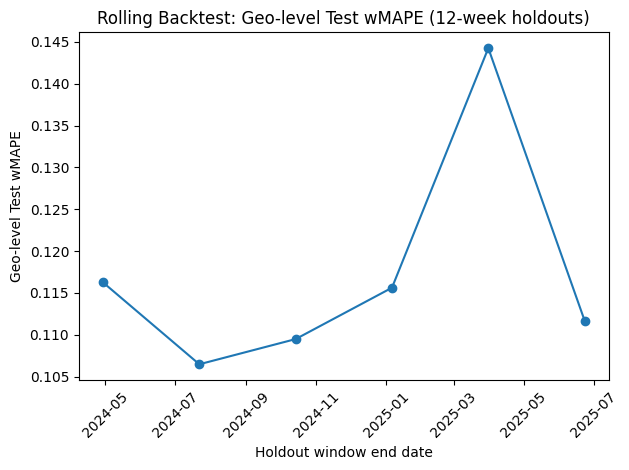

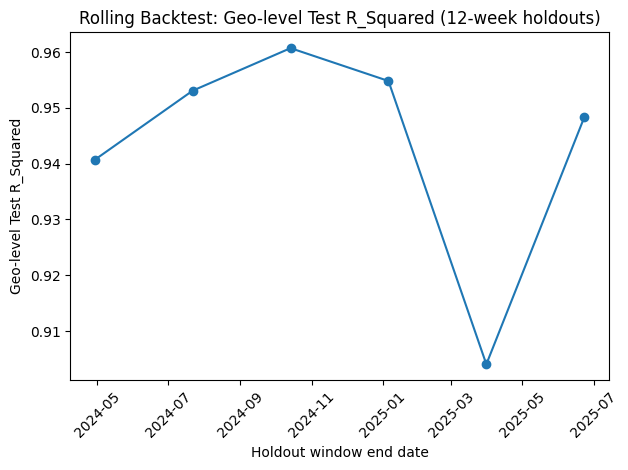

In [ ]:
# Plot rolling TEST performance (geo-level wMAPE and R^2)

import matplotlib.pyplot as plt

# 1) Keep TEST rows only
test_wide = wide[wide["evaluation_set"] == "Test"].copy()
test_wide["window_end"] = pd.to_datetime(test_wide["window_end"])
test_wide["geo_level"] = pd.to_numeric(test_wide["geo_level"], errors="coerce")

# 2) Build a per-split table with geo-level metrics
per = (
    test_wide.pivot_table(
        index=["split_id", "window_end"],
        columns="metric",
        values="geo_level"
    )
    .reset_index()
    .sort_values("window_end")
)

# Plot 1: geo-level TEST wMAPE over time (by holdout window end)
plt.figure()
plt.plot(per["window_end"], per["wMAPE"], marker="o")
plt.xlabel("Holdout window end date")
plt.ylabel("Geo-level Test wMAPE")
plt.title("Rolling Backtest: Geo-level Test wMAPE (12-week holdouts)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: geo-level TEST R_Squared over time
plt.figure()
plt.plot(per["window_end"], per["R_Squared"], marker="o")
plt.xlabel("Holdout window end date")
plt.ylabel("Geo-level Test R_Squared")
plt.title("Rolling Backtest: Geo-level Test R_Squared (12-week holdouts)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#Convert inc_tensor -> tidy contribution table + shares

#  4 channels (from builder)
media_channels = ["TV", "Facebook", "Print", "Radio"]

tidy_rows = []

for _, r in raw_inc_df.iterrows():
    split_id = int(r["split_id"])
    w_start = r["window_start"]
    w_end   = r["window_end"]

    inc = np.array(r["inc_tensor"])  # (n_chains, n_draws, n_channels)
    # flatten chains+draws -> samples
    samples = inc.reshape(-1, inc.shape[-1])  # (n_samples, n_channels)

    # summarize each channel
    mean = samples.mean(axis=0)
    p10  = np.percentile(samples, 10, axis=0)
    p50  = np.percentile(samples, 50, axis=0)
    p90  = np.percentile(samples, 90, axis=0)

    # shares (per posterior sample): channel / total across channels
    total = samples.sum(axis=1, keepdims=True)  # (n_samples, 1)
    share = samples / np.clip(total, 1e-12, None)

    share_mean = share.mean(axis=0)
    share_p10  = np.percentile(share, 10, axis=0)
    share_p50  = np.percentile(share, 50, axis=0)
    share_p90  = np.percentile(share, 90, axis=0)

    for j, ch in enumerate(media_channels):
        tidy_rows.append({
            "split_id": split_id,
            "window_start": w_start,
            "window_end": w_end,
            "channel": ch,
            "inc_mean": float(mean[j]),
            "inc_p10": float(p10[j]),
            "inc_p50": float(p50[j]),
            "inc_p90": float(p90[j]),
            "share_mean": float(share_mean[j]),
            "share_p10": float(share_p10[j]),
            "share_p50": float(share_p50[j]),
            "share_p90": float(share_p90[j]),
        })

contrib_tidy = pd.DataFrame(tidy_rows)
display(contrib_tidy.sort_values(["split_id","channel"]).head(20))


,split_id,window_start,window_end,channel,inc_mean,inc_p10,inc_p50,inc_p90,share_mean,share_p10,share_p50,share_p90
1,0,2025-04-07,2025-06-23,Facebook,5.157345e+05,2.173944e+05,4.456702e+05,9.069439e+05,0.120847,0.050542,0.106848,0.211378
2,0,2025-04-07,2025-06-23,Print,9.501470e+05,3.606564e+05,7.974179e+05,1.740647e+06,0.213935,0.091710,0.195215,0.362467
3,0,2025-04-07,2025-06-23,Radio,1.439259e+06,6.191120e+05,1.272641e+06,2.462118e+06,0.320526,0.164118,0.309666,0.491530
0,0,2025-04-07,2025-06-23,TV,1.484774e+06,9.041509e+05,1.382903e+06,2.156515e+06,0.344693,0.214175,0.335850,0.485980
5,1,2025-01-13,2025-03-31,Facebook,6.543101e+05,3.023523e+05,5.933615e+05,1.087017e+06,0.151303,0.068865,0.138308,0.251091
6,1,2025-01-13,2025-03-31,Print,9.518730e+05,3.618551e+05,8.006272e+05,1.741346e+06,0.211272,0.091008,0.193045,0.359224
7,1,2025-01-13,2025-03-31,Radio,1.342047e+06,5.523706e+05,1.174996e+06,2.349960e+06,0.294299,0.143752,0.281736,0.462235
4,1,2025-01-13,2025-03-31,TV,1.499388e+06,9.155604e+05,1.397421e+06,2.173076e+06,0.343126,0.214213,0.334680,0.482182
9,2,2024-10-21,2025-01-06,Facebook,6.635182e+05,3.057574e+05,6.018310e+05,1.106286e+06,0.134609,0.061377,0.122816,0.224134
10,2,2024-10-21,2025-01-06,Print,1.067749e+06,4.441786e+05,9.233501e+05,1.884410e+06,0.209421,0.096418,0.193082,0.345602


<Figure size 640x480 with 0 Axes>

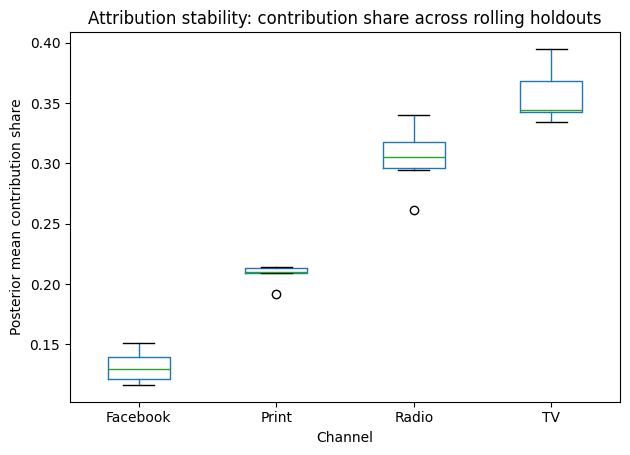

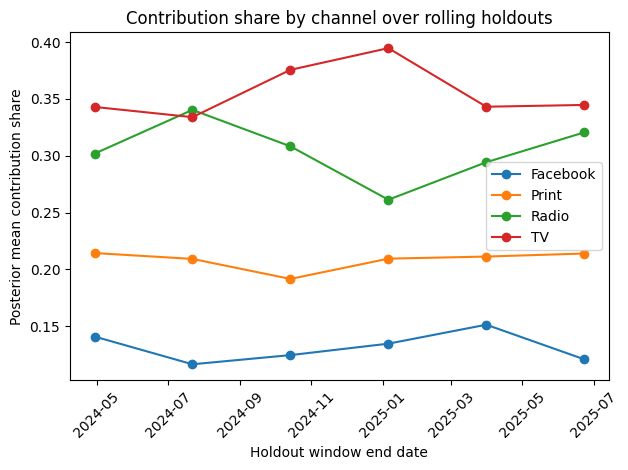

In [ ]:
# Plot stability of channel contribution shares
df = contrib_tidy.copy()
df["window_end"] = pd.to_datetime(df["window_end"])

#  Plot 1: Boxplot of posterior mean share by channel across splits
plt.figure()
df.boxplot(column="share_mean", by="channel", grid=False)
plt.title("Attribution stability: contribution share across rolling holdouts")
plt.suptitle("")  # remove pandas default subtitle
plt.xlabel("Channel")
plt.ylabel("Posterior mean contribution share")
plt.tight_layout()
plt.show()

#  Plot 2: Line plot of share_mean over time (one line per channel)
pivot = (
    df.pivot_table(index="window_end", columns="channel", values="share_mean")
      .sort_index()
)

plt.figure()
for ch in pivot.columns:
    plt.plot(pivot.index, pivot[ch], marker="o", label=ch)

plt.xlabel("Holdout window end date")
plt.ylabel("Posterior mean contribution share")
plt.title("Contribution share by channel over rolling holdouts")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# most recent TEST window (split 0)
split0_test_times = [pd.Timestamp(t).strftime("%Y-%m-%d") for t in holdout_weeks.to_list()]

# ROI by channel for that window
roi = anlz.roi(selected_times=split0_test_times)


/tmp/ipython-input-2846572644.py:6: DeprecationWarning: The `meridian` argument is deprecated and will be removed in a future version. Use `model_context` instead.
  anlz = analyzer.Analyzer(mmm)


roi tensor shape: (10, 1000, 4)


,channel,roi_mean,roi_p10,roi_p50,roi_p90
0,TV,0.230420,0.140314,0.214610,0.334666
3,Radio,0.223356,0.096079,0.197499,0.382092
2,Print,0.147451,0.055970,0.123750,0.270128
1,Facebook,0.080036,0.033737,0.069163,0.140747


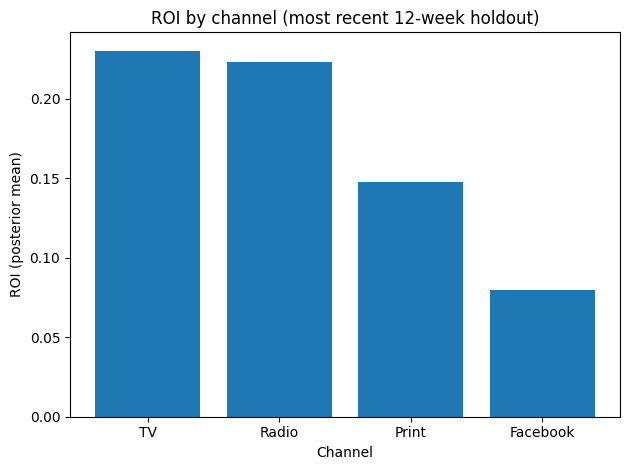

In [ ]:

# Most recent holdout window (split 0 test)
split0_test_times = [pd.Timestamp(t).strftime("%Y-%m-%d") for t in holdout_weeks.to_list()]
media_channels = ["TV", "Facebook", "Print", "Radio"]  #  channel order

roi = anlz.roi(selected_times=split0_test_times)

# Convert ROI output to numpy
roi_np = np.array(roi)

print("roi tensor shape:", roi_np.shape)

# If ROI has (chains, draws, channels) like incremental_outcome:
if roi_np.ndim == 3 and roi_np.shape[-1] == len(media_channels):
    samples = roi_np.reshape(-1, roi_np.shape[-1])  # (n_samples, n_channels)
    roi_mean = samples.mean(axis=0)
    roi_p10  = np.percentile(samples, 10, axis=0)
    roi_p50  = np.percentile(samples, 50, axis=0)
    roi_p90  = np.percentile(samples, 90, axis=0)

    roi_df = pd.DataFrame({
        "channel": media_channels,
        "roi_mean": roi_mean,
        "roi_p10": roi_p10,
        "roi_p50": roi_p50,
        "roi_p90": roi_p90,
    }).sort_values("roi_mean", ascending=False)

    display(roi_df)

    # Plot
    plt.figure()
    plt.bar(roi_df["channel"], roi_df["roi_mean"])
    plt.xlabel("Channel")
    plt.ylabel("ROI (posterior mean)")
    plt.title("ROI by channel (most recent 12-week holdout)")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("ROI returned an unexpected shape. Paste the printed shape and I’ll adapt the converter.")


/tmp/ipython-input-1346795336.py:6: DeprecationWarning: The `meridian` argument is deprecated and will be removed in a future version. Use `model_context` instead.
  anlz = analyzer.Analyzer(mmm)


marginal_roi shape: (10, 1000, 4)


,channel,marginal_roi_mean
0,TV,0.107823
3,Radio,0.059374
2,Print,0.032961
1,Facebook,0.031626


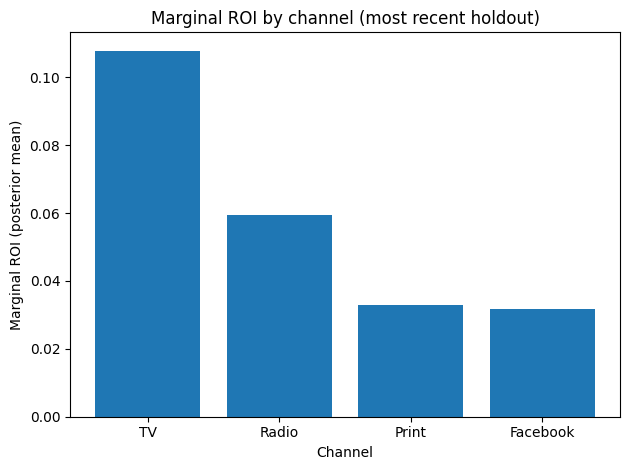

In [ ]:

split0_test_times = [pd.Timestamp(t).strftime("%Y-%m-%d") for t in holdout_weeks.to_list()]
media_channels = ["TV", "Facebook", "Print", "Radio"]

mroi = anlz.marginal_roi(selected_times=split0_test_times)
mroi_np = np.array(mroi)

print("marginal_roi shape:", mroi_np.shape)

# Common pattern: (chains, draws, channels) OR (chains, draws, channels, grid)
#  detect a "grid" dimension if present.
if mroi_np.ndim == 3 and mroi_np.shape[-1] == len(media_channels):
    # summarize per channel
    samples = mroi_np.reshape(-1, mroi_np.shape[-1])
    mroi_mean = samples.mean(axis=0)

    mroi_df = pd.DataFrame({"channel": media_channels, "marginal_roi_mean": mroi_mean}) \
               .sort_values("marginal_roi_mean", ascending=False)
    display(mroi_df)

    plt.figure()
    plt.bar(mroi_df["channel"], mroi_df["marginal_roi_mean"])
    plt.xlabel("Channel")
    plt.ylabel("Marginal ROI (posterior mean)")
    plt.title("Marginal ROI by channel (most recent holdout)")
    plt.tight_layout()
    plt.show()

elif mroi_np.ndim == 4 and mroi_np.shape[-2] == len(media_channels):
    # Has a grid dimension: (..., channels, grid)
    # Flatten chains/draws, keep channels x grid
    samples = mroi_np.reshape(-1, mroi_np.shape[-2], mroi_np.shape[-1])  # (n_samples, C, G)
    mean_curve = samples.mean(axis=0)  # (C, G)

    # x-axis: grid index (label it as "spend multiplier index" unless Meridian returns actual multipliers)
    x = np.arange(mean_curve.shape[1])

    plt.figure()
    for j, ch in enumerate(media_channels):
        plt.plot(x, mean_curve[j], marker="o", label=ch)

    plt.xlabel("Spend multiplier grid (index)")
    plt.ylabel("Marginal ROI (posterior mean)")
    plt.title("Marginal ROI curves (diminishing returns) — most recent holdout")
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("Unexpected marginal_roi shape. Paste the shape + a small slice like mroi_np[0,0,...].")


,scenario,shift_fraction,shift_amount,roi_from,roi_to,expected_delta_outcome
0,Facebook → TV,0.1,644378.603618,0.080036,0.230420,96904.040811
1,Facebook → Radio,0.1,644378.603618,0.080036,0.223356,92352.505775


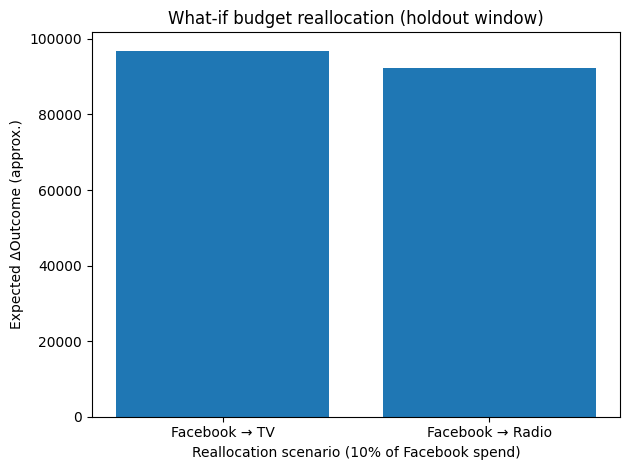

In [ ]:

# Use the same shift_amount computed in Step 1
shift_frac = 0.10
shift_amount = shift_frac * holdout_spend["Facebook"]

scenarios = [
    ("Facebook", "TV"),
    ("Facebook", "Radio"),
]

rows = []
for frm, to in scenarios:
    delta = (roi_mean[to] - roi_mean[frm]) * shift_amount
    rows.append({
        "scenario": f"{frm} → {to}",
        "shift_fraction": shift_frac,
        "shift_amount": shift_amount,
        "roi_from": roi_mean[frm],
        "roi_to": roi_mean[to],
        "expected_delta_outcome": delta,
    })

whatif_df = pd.DataFrame(rows).sort_values("expected_delta_outcome", ascending=False)
display(whatif_df)

# Plot
plt.figure()
plt.bar(whatif_df["scenario"], whatif_df["expected_delta_outcome"])
plt.xlabel("Reallocation scenario (10% of Facebook spend)")
plt.ylabel("Expected ΔOutcome (approx.)")
plt.title("What-if budget reallocation (holdout window)")
plt.tight_layout()
plt.show()
